### Imports and Version Check

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import sys, os
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow_model_optimization as tfmot
import shap
import keras
import matplotlib.cm as cm
from IPython.display import Image
import pandas as pd
import seaborn as sns

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# sess.as_default()

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# for physical_device in physical_devices:
#     tf.config.experimental.set_memory_growth(physical_device, True)

In [2]:
tf.test.gpu_device_name()

''

In [3]:
tf.__version__

'2.3.0'

In [4]:
%matplotlib inline

In [5]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Data Generator

In [8]:
train_data_dir = '../../TinyCollision/data/CollisionData/'

img_width, img_height = 96, 96 # 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 25
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data

Found 730 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


## Model Architectures

In [10]:
models = [] # #0 for custom CNN, #1 for mobilenet

### Custom CNN

Tiny Compatible

In [11]:
finetune_model_CNN = tf.keras.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

finetune_model_CNN._name="Custom_CNN"

finetune_model_CNN.compile(
    optimizer=tf.keras.optimizers.Adam(lr = 1e-5, decay = 1e-5),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [12]:
models.append(finetune_model_CNN)

In [13]:
finetune_model_CNN.summary()

Model: "Custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0

### MobileNet V1

All layer trainable, imagenet initialized

In [14]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True #change this to False is retraining is not to be done in base layers

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(1, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

base_model = MobileNet(weights='imagenet', 
                      include_top=False, 
                      input_shape=input_shape)

class_list = ['CollisionOrClose', 'NoCollision']
FC_LAYERS = [256, 256]
dropout = 0.5

finetune_model_MN = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

finetune_model_MN._name="Mobile_Net_V1"

finetune_model_MN.compile(
    optimizer=tf.keras.optimizers.Adam(lr = 1e-5, decay = 1e-5),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [15]:
models.append(finetune_model_MN)

In [16]:
finetune_model_MN.summary()

Model: "Mobile_Net_V1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 97, 97, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 48, 48, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 48, 48, 32)      

## Training and Testing

In [17]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 15,
                 min_delta=0.001, restore_best_weights=True
             )
]

history = []

for each in models:
    print("="*40)
    print("Training and Testing Model: %s" % str(each.name))
    temp_history = each.fit(train_generator, 
        steps_per_epoch = nb_train_samples // batch_size, 
        epochs = epochs, validation_data = validation_generator, 
        validation_steps = nb_validation_samples // batch_size, shuffle=True, callbacks = callbacks) 
    print("="*40)
    history.append(temp_history)


Training and Testing Model: Custom_CNN
Epoch 1/25
45/45 [==============================] - 11s 253ms/step - loss: 0.6865 - accuracy: 0.6106 - val_accuracy: 0.7670 - val_loss: 0.6670
Epoch 2/25
45/45 [==============================] - 11s 248ms/step - loss: 0.5280 - accuracy: 0.7339 - val_accuracy: 0.7670 - val_loss: 0.6549
Epoch 3/25
45/45 [==============================] - 11s 246ms/step - loss: 0.4974 - accuracy: 0.7465 - val_accuracy: 0.7670 - val_loss: 0.6488
Epoch 4/25
45/45 [==============================] - 11s 248ms/step - loss: 0.4799 - accuracy: 0.7675 - val_accuracy: 0.7670 - val_loss: 0.6312
Epoch 5/25
45/45 [==============================] - 11s 246ms/step - loss: 0.4419 - accuracy: 0.7983 - val_accuracy: 0.7670 - val_loss: 0.6136
Epoch 6/25
45/45 [==============================] - 11s 247ms/step - loss: 0.4321 - accuracy: 0.7871 - val_accuracy: 0.8011 - val_loss: 0.5905
Epoch 7/25
45/45 [==============================] - 11s 245ms/step - loss: 0.4284 - accuracy: 0.7857 - 

#### Save models and metrics

In [18]:
for idx,each in enumerate(models):
    model_file = '../my-log-dir/saved_model/' + str(each.name) + '.h5'
    each.save(model_file)
    
    metrics_df = pd.DataFrame(
                {'accuracy' : history[idx].history['accuracy'],
                'validation_accuracy' : history[idx].history['val_accuracy'],
                'loss': history[idx].history['loss'],
                'validation_loss' : history[idx].history['val_loss']
                }
        )
    
    metrics_file = '../my-log-dir/' + str(each.name) + '.csv'
    metrics_df.to_csv(metrics_file)

### Model Summary

#### Number of Parameters

In [19]:
for each in models:
    print("Number of parameters:  %s" % str(each.name))
    print(each.count_params())

Number of parameters:  Custom_CNN
1258829
Number of parameters:  Mobile_Net_V1
5654465


#### Number of Ops

In [20]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

    tf.compat.v1.reset_default_graph()

    return flops.total_float_ops

for each in models:
    model_file = '../my-log-dir/saved_model/' + str(each.name) + '.h5'
    print("Number of OPS:  %s" % str(each.name))
    print(get_flops(model_file))

Number of OPS:  Custom_CNN
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
2516668
Number of OPS:  Mobile_Net_V1
11264214


#### Model Size

In [21]:
import os

for each in models:
    model_file = '../my-log-dir//saved_model/' + str(each.name) + '.h5'
    print("Model:  %s" % str(each.name))
    b = os.path.getsize(model_file)
    print ("Size(mb): %d" % (b/1000000))



Model:  Custom_CNN
Size(mb): 15
Model:  Mobile_Net_V1
Size(mb): 68


### Performance

#### Metric Plots

In [22]:
sns.color_palette("tab10")
sns.set()
sns.set_style(style='white')

Metrics for: Custom_CNN


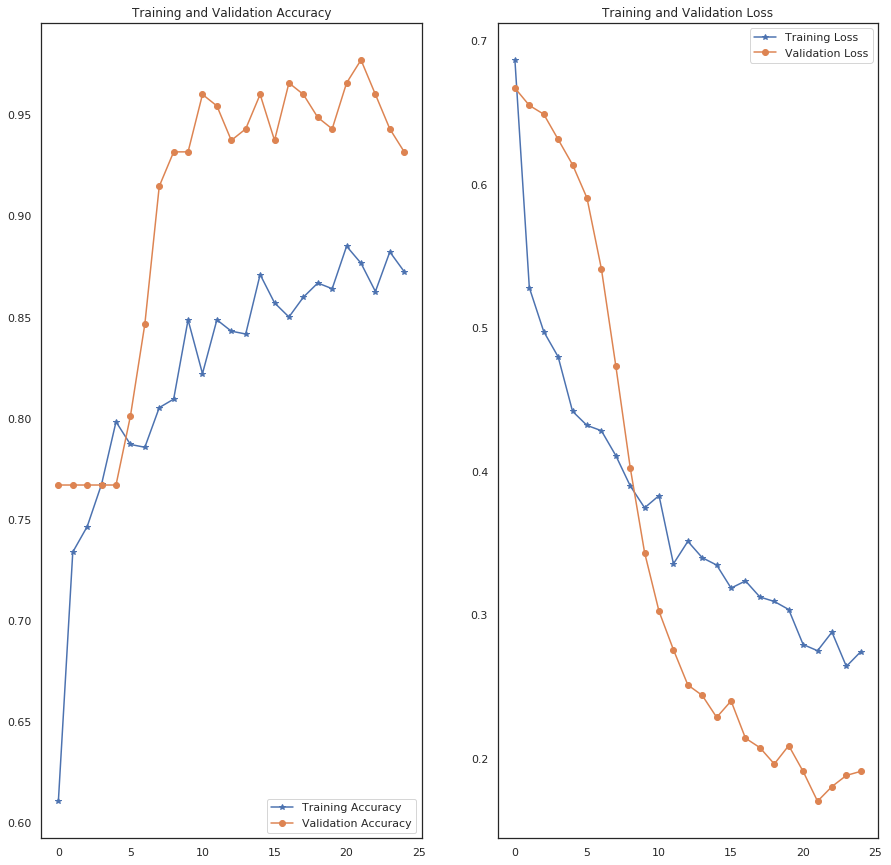

Metrics for: Mobile_Net_V1


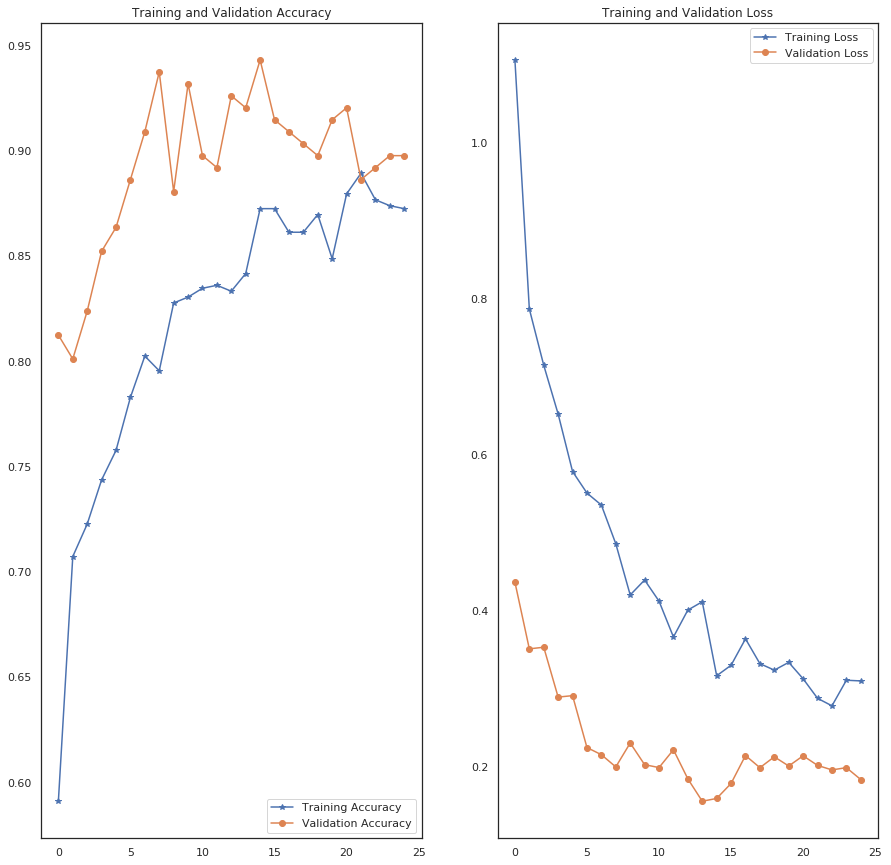

In [23]:
for each in models:
    metrics_file = '../my-log-dir/' + str(each.name) + '.csv'
    met_df = pd.read_csv(metrics_file)

    print("Metrics for: %s" % each.name)
    acc = met_df['accuracy']
    val_acc = met_df['validation_accuracy']

    loss=met_df['loss']
    val_loss=met_df['validation_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, marker="*", label='Training Accuracy')
    plt.plot(epochs_range, val_acc, marker="o", label='Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.grid(b=None)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, marker="*", label='Training Loss')
    plt.plot(epochs_range, val_loss, marker="o", label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### Confusion Matrix

Evaluating model: Custom_CNN
Instructions for updating:
Please use Model.predict, which supports generators.
                  precision    recall  f1-score   support

     NoCollision       0.91      0.95      0.93        41
CollisionOrClose       0.99      0.97      0.98       140

        accuracy                           0.97       181
       macro avg       0.95      0.96      0.95       181
    weighted avg       0.97      0.97      0.97       181

Confusion Matrix
[[ 39   2]
 [  4 136]]
Evaluating model: Mobile_Net_V1
                  precision    recall  f1-score   support

     NoCollision       0.67      0.90      0.77        41
CollisionOrClose       0.97      0.87      0.92       140

        accuracy                           0.88       181
       macro avg       0.82      0.89      0.84       181
    weighted avg       0.90      0.88      0.88       181

Confusion Matrix
[[ 37   4]
 [ 18 122]]


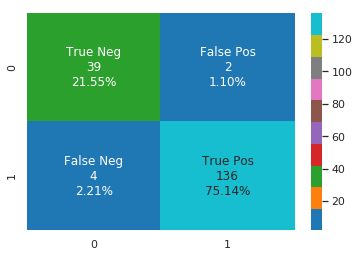

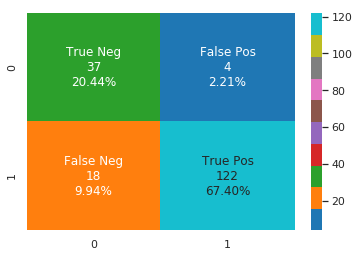

In [24]:
from sklearn.metrics import confusion_matrix
from keras.utils import Sequence

for idx,each in enumerate(models):
    print("Evaluating model: %s" % str(each.name))
    model_file = '../my-log-dir/saved_model/' + str(each.name) + '.h5'
    model = tf.keras.models.load_model(model_file)
    
    probabilities = model.predict_generator(generator=validation_generator)
    y_true = validation_generator.classes
    y_pred = probabilities > 0.5
    class_labels = list(validation_generator.class_indices.keys())  

    report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
    print(report) 
    
    print('Confusion Matrix')
    mat = confusion_matrix(y_true, y_pred)
    print(mat)
    
    
    plt.figure(idx)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in mat.flatten()/np.sum(mat)]
    labels = [v1 + '\n' + v2 + '\n' + v3 for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(mat, annot=labels, fmt='', cmap="tab10") #tab10 for colorblind otherwise use blues, etc.
    
    
#     sns.heatmap(mat, annot=True)
    print('='*40)

### Analyze Results

***Using custom CNN for here on***

In [25]:
model_file = '../my-log-dir/saved_model/Custom_CNN.h5'
model = tf.keras.models.load_model(model_file)

In [26]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<Figure size 1440x1440 with 0 Axes>

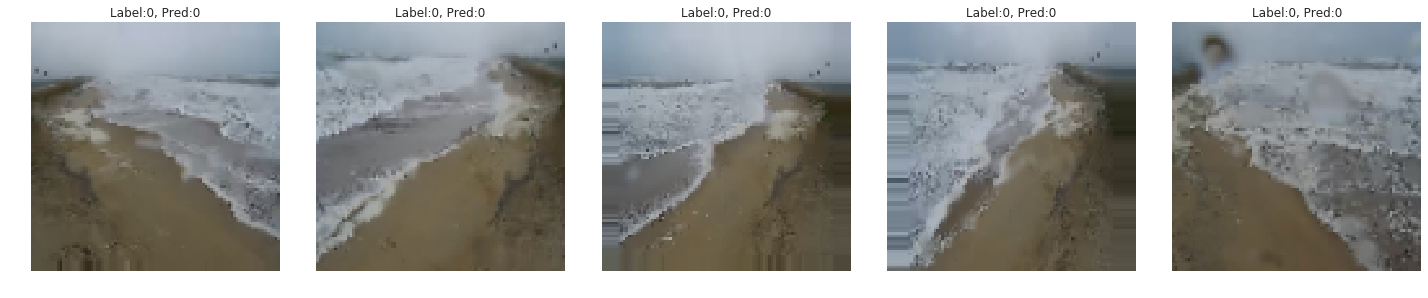

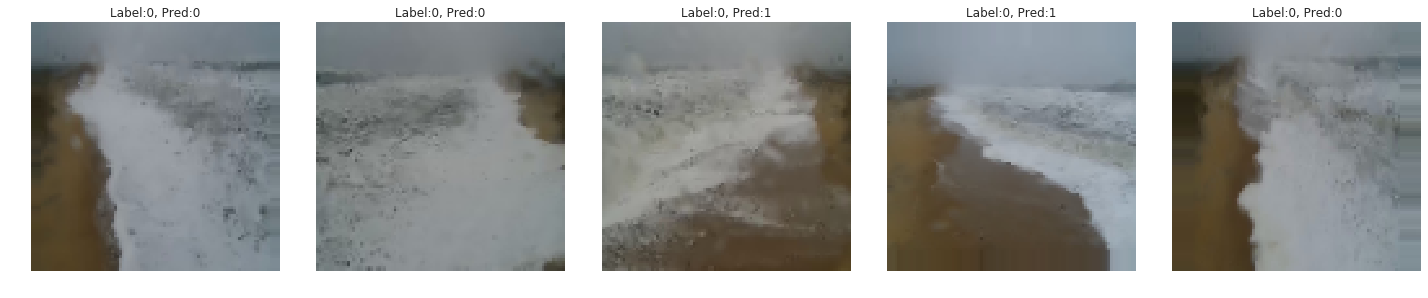

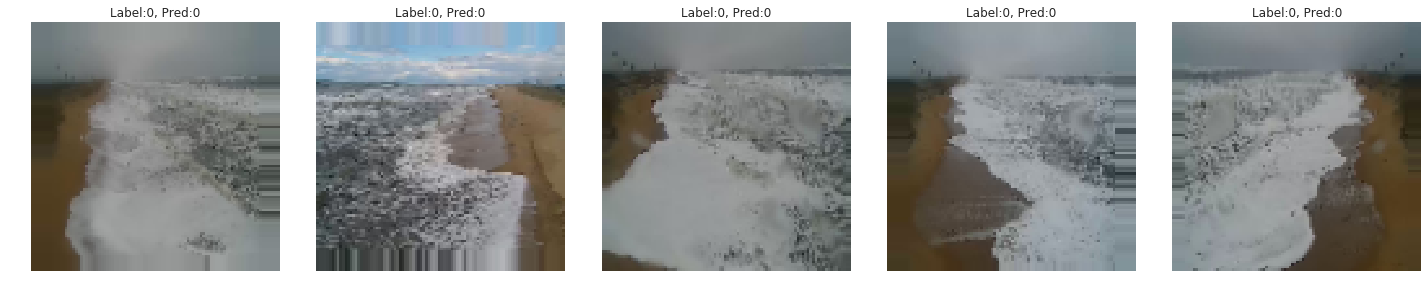

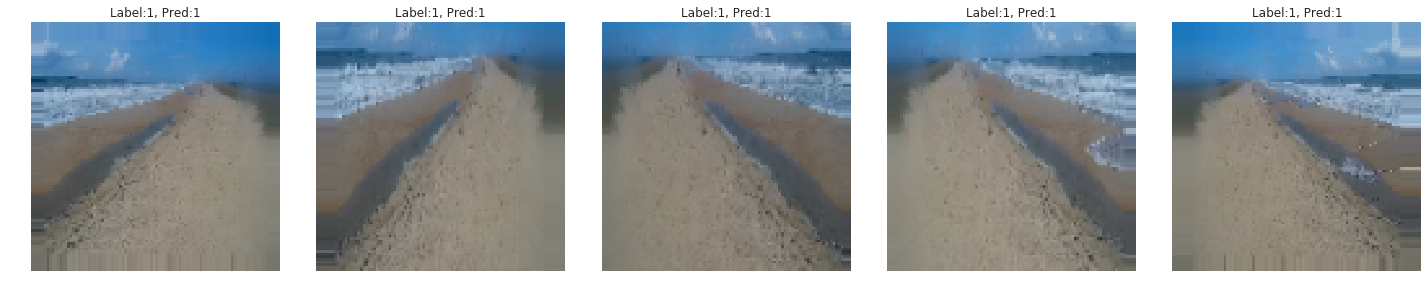

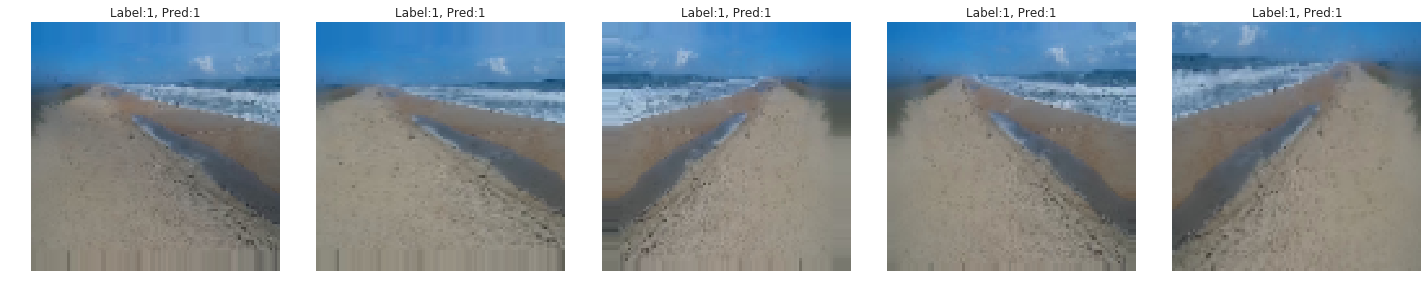

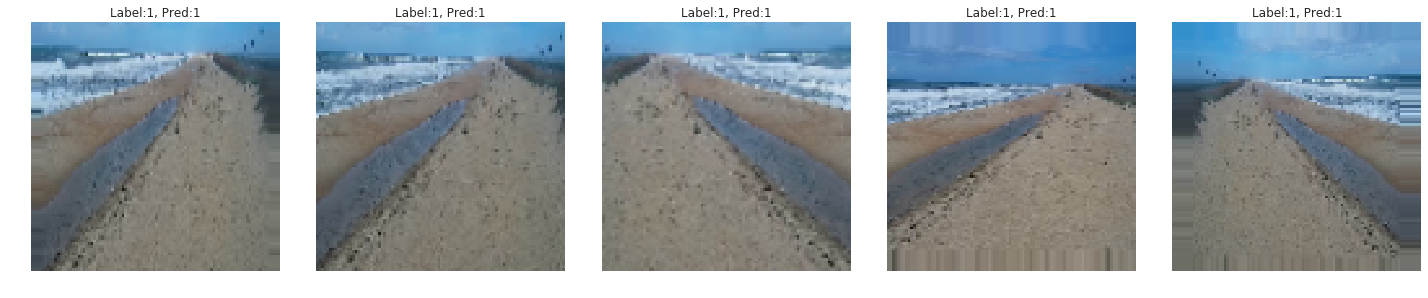

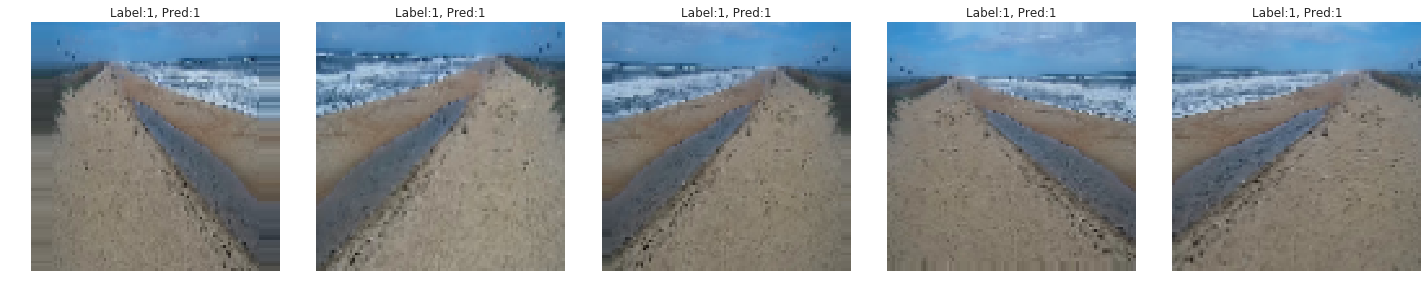

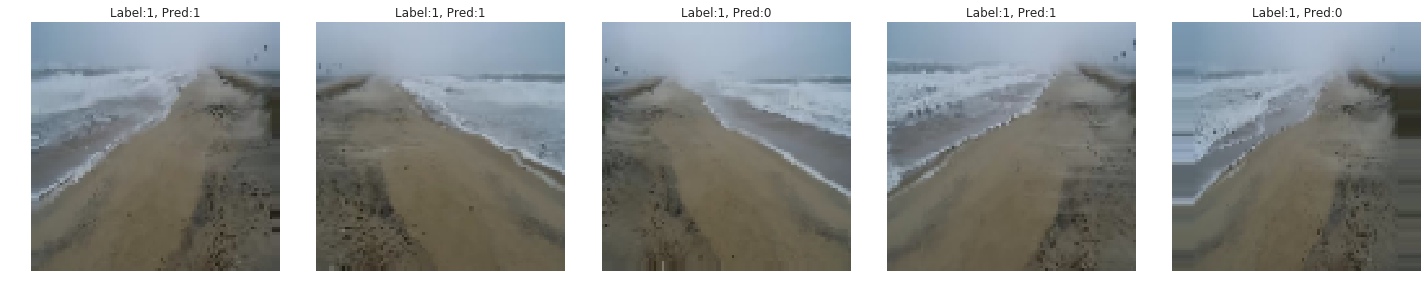

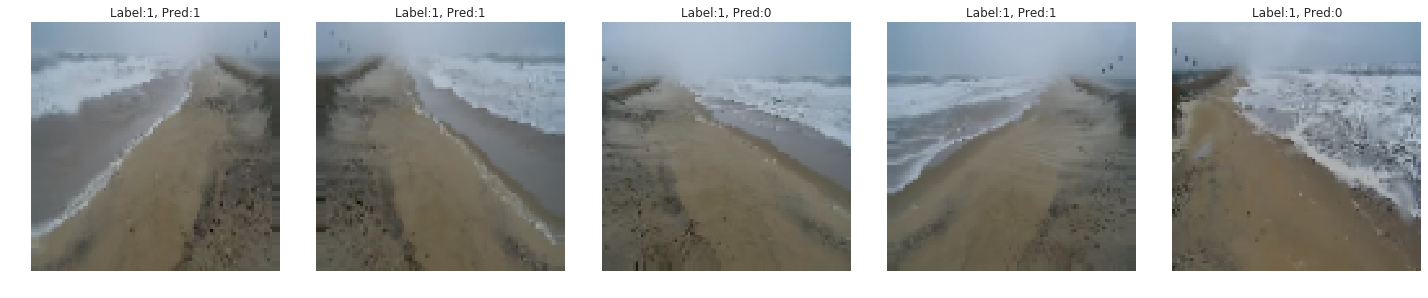

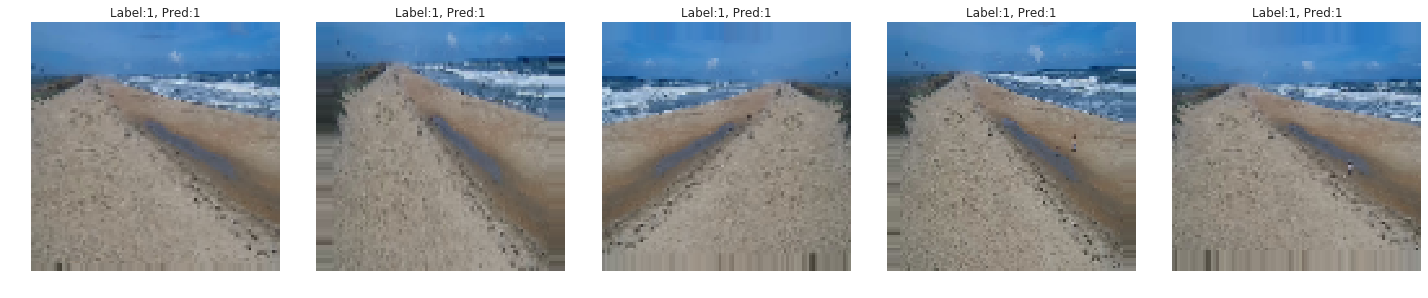

In [27]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

### GradCam

In [28]:
#from https://keras.io/examples/vision/grad_cam/

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = imsize)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    #grads = tape.gradient(bottom_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [29]:
gradcam_layers = []

for each in model.layers:
    if each._name.startswith('max_pooling2d'):
        last_conv_layer_name = each._name
    gradcam_layers.append(each._name)
classifier_layer_names = gradcam_layers[-6:]

print(last_conv_layer_name)
print(classifier_layer_names)

max_pooling2d_2
['flatten', 'dense', 'dropout', 'dense_1', 'dropout_1', 'dense_2']


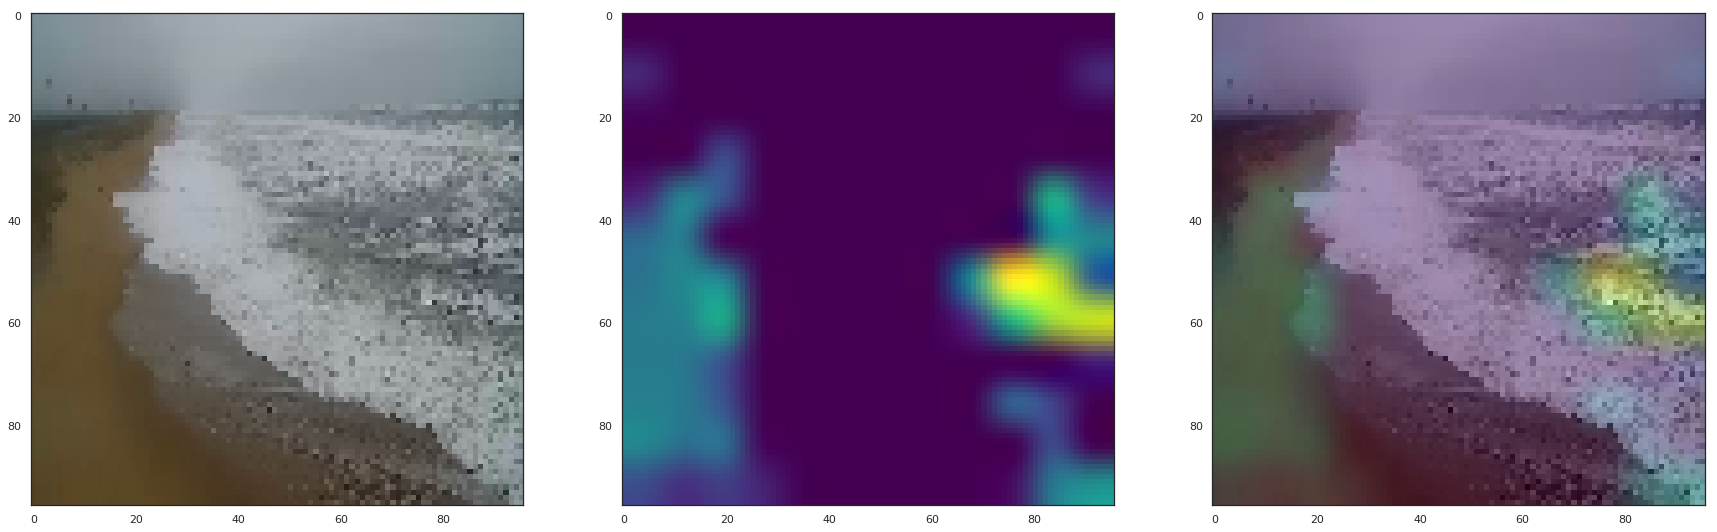

In [30]:
#from https://keras.io/examples/vision/grad_cam/
# Prepare image

fp = "../../TinyCollision/data/CollisionData/CollisionOrClose/"
ip = "20200625103932229722.jpg"

pix_dim = 96
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)



# last_conv_layer_name = "max_pooling2d_2"
# classifier_layer_names = [
#     "flatten",
#     "dense",
#     "dropout",
#     "dense_1",
#     "dropout_1",
#     "dense_2"
# ]

impath = str(fp) + str(ip)
img = tf.keras.preprocessing.image.load_img(impath,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img_array = np.expand_dims(img,axis=0)


# Make the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)
    
# get the original ERI image
Orimg = tf.keras.preprocessing.image.load_img(impath, target_size = imsize)
Orimg = tf.keras.preprocessing.image.img_to_array(Orimg)

# rescale image (range 0-255)
heatmap = np.uint8(255 * heatmap)

# use viridis for heatmap
vir = cm.get_cmap("viridis")
vir_colors = vir(np.arange(256))[:, :3]
vir_heatmap = vir_colors[heatmap]

# make the heatmap
vir_heatmap = tf.keras.preprocessing.image.array_to_img(vir_heatmap)
vir_heatmapI = vir_heatmap.resize((Orimg.shape[1], Orimg.shape[0]))
vir_heatmap = tf.keras.preprocessing.image.img_to_array(vir_heatmapI)

#put heatmpa on image
superimposed_img = vir_heatmap * 0.4 + Orimg
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Display Image, heatmap and overlay
# Display heatmap
plt.figure(figsize=(30,30))
plt.subplot(131)
plt.imshow(tf.keras.preprocessing.image.load_img(impath, target_size = imsize))
plt.subplot(132)
plt.imshow(vir_heatmapI)
plt.subplot(133)
plt.imshow(superimposed_img)
    
#save it
#plt.savefig('images/FPgrad_{}.pdf'.format(ip), format='pdf')

# Optimization

## Pruning

In [31]:
end_step = np.ceil(1.0 * nb_train_samples / batch_size).astype(np.int32) * epochs

pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)
model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "Custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 96, 96, 3)         13        
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 96, 96, 16)        2418      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 48, 48, 16)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 48, 48, 16)        65        
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 48, 48, 32)        9250      
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 48, 48, 32)        18466     
_________________________________________________

In [32]:
logdir = '../my-log-dir/'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
  
model_for_pruning.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True, callbacks = callbacks)

Epoch 1/25
 1/45 [..............................] - ETA: 0s - loss: 0.3822 - accuracy: 0.7500WARNING:tensorflow:From /home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
45/45 [==============================] - 12s 258ms/step - loss: 0.4287 - accuracy: 0.7787 - val_accuracy: 0.8750 - val_loss: 0.2509
Epoch 2/25
45/45 [==============================] - 11s 248ms/step - loss: 0.3708 - accuracy: 0.8389 - val_accuracy: 0.9318 - val_loss: 0.1664
Epoch 3/25
45/45 [==============================] - 11s 250ms/step - loss: 0.2996 - accuracy: 0.8515 - val_accuracy: 0.9602 - val_loss: 0.1261
Epoch 4/25
45/45 [==============================] - 11s 248ms/step - loss: 0.2678 - accuracy: 0.8894 - val_accuracy: 0.9489 - val_loss: 0.2056
Epoch 5/25
45/45 [=====================

#### Pruned Model Evaluation

In [33]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(validation_generator, verbose=0)

print('Custom CNN Pruned test accuracy:', model_for_pruning_accuracy)

Custom CNN Pruned test accuracy: 0.9171270728111267


#### Export Pruned Model

In [34]:
from tensorflow_model_optimization.sparsity import keras as sparsity

final_model = sparsity.strip_pruning(model_for_pruning)
final_model.summary()

Model: "Custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0

In [35]:
from tensorflow.keras.models import load_model
import numpy as np

# model = tf.keras.models.load_model(final_model)


for i, w in enumerate(final_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            final_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

batch_normalization/gamma:0 -- Total:3, Zeros: 0.00%
batch_normalization/beta:0 -- Total:3, Zeros: 0.00%
batch_normalization/moving_mean:0 -- Total:3, Zeros: 0.00%
batch_normalization/moving_variance:0 -- Total:3, Zeros: 0.00%
conv2d/kernel:0 -- Total:1200, Zeros: 90.00%
conv2d/bias:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/gamma:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/beta:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/moving_mean:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/moving_variance:0 -- Total:16, Zeros: 0.00%
conv2d_1/kernel:0 -- Total:4608, Zeros: 90.00%
conv2d_1/bias:0 -- Total:32, Zeros: 0.00%
conv2d_2/kernel:0 -- Total:9216, Zeros: 90.00%
conv2d_2/bias:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/gamma:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/beta:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/moving_mean:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/moving_variance:0 -- Total:32, Zeros: 0.00%
conv2d_3/kernel:0 -- Total:18432

##### Pruned Model Size

In [36]:
import tempfile
import zipfile

# _, new_pruned_keras_file = tempfile.mkstemp(".h5")

new_pruned_keras_file = "../my-log-dir/saved_model/pruned_model.pb"
print("Saving pruned model to: ", new_pruned_keras_file)
tf.keras.models.save_model(final_model, new_pruned_keras_file, include_optimizer=False)
print(
    "Size of the pruned model: %.2f Mb"
    % (os.path.getsize(new_pruned_keras_file) / float(2 ** 20))
)

Saving pruned model to:  ../my-log-dir/saved_model/pruned_model.pb
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../my-log-dir/saved_model/pruned_model.pb/assets
Size of the pruned model: 0.00 Mb


## Quantize

#### Post training quantization
##### Full integer quantization. 

To 8-bits

In [37]:
keras_model = tf.keras.models.load_model(new_pruned_keras_file)

tflite_fullint_model_file = "../my-log-dir/saved_model/post_fullint_quantized.tflite"

# converter = tf.lite.TFLiteConverter.from_saved_model('../log/saved_model/pruned_model.pb')

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]



num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()
with open(tflite_fullint_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0c534id1/assets
(181, 96, 96, 3)


#####  Quantized Model Size

In [38]:
print(
    "Size of the quantized model before compression: %.2f Mb"
    % (os.path.getsize(tflite_fullint_model_file) / float(2 ** 20))
)

Size of the quantized model before compression: 1.22 Mb


#### Quantized Model Evaluation

In [39]:
x=[]
y=[]
validation_generator.reset()
x=np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
y=np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])
print(x.shape)
print(y.shape)

(181, 96, 96, 3)
(181,)


In [40]:

interpreter = tf.lite.Interpreter(model_path=str(tflite_fullint_model_file))

interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

preds = []

y_pred = []
y_true = []

def eval_model(interpreter, x_test, y_test):
    total_seen = 0
    num_correct = 0

    for img, label in zip(x_test, y_test):
        
        if input_details['dtype'] == np.int8:
            input_scale, input_zero_point = input_details["quantization"]
            img = img / input_scale + input_zero_point
        
        inp = np.expand_dims(img, axis=0).astype(input_details["dtype"]) #change here for different quantization
        
        total_seen += 1
        interpreter.set_tensor(input_index, inp) 
        interpreter.invoke()
        
        predictions = interpreter.get_tensor(output_index)
        print(predictions)
        preds.append(predictions[0][0])
        if predictions[0][0] > 0: ### needs to be changed for int quantization
            predicted = 1
        else:
            predicted = 0
        y_pred.append(predicted)
        y_true.append(label)
        if predicted == label:
            num_correct += 1
            
        if total_seen % 1000 == 0:
            print("Accuracy after %i images: %f" %
                  (total_seen, float(num_correct) / float(total_seen)))

    return float(num_correct) / float(total_seen)

print(eval_model(interpreter, x, y))



[[-119]]
[[-118]]
[[-115]]
[[-115]]
[[-106]]
[[-113]]
[[-119]]
[[-126]]
[[-118]]
[[-127]]
[[-116]]
[[-112]]
[[-116]]
[[-122]]
[[-121]]
[[-93]]
[[-123]]
[[-120]]
[[-118]]
[[0]]
[[-98]]
[[-112]]
[[-16]]
[[-102]]
[[-71]]
[[-5]]
[[-126]]
[[-124]]
[[-114]]
[[-110]]
[[-127]]
[[-120]]
[[-125]]
[[-36]]
[[-126]]
[[-116]]
[[-120]]
[[-123]]
[[-127]]
[[-124]]
[[-117]]
[[127]]
[[127]]
[[125]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[124]]
[[127]]
[[125]]
[[126]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[125]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[127]]
[[-102]]
[[-64]]
[[-16]]
[[67]]
[[5]]
[[117]]
[[16]]
[[36]]
[[55]]
[[85]]
[[-21]]
[[-16]]
[[31]]
[[0]]
[[41]]
[[-90]]
[[88]]
[[78]]
[[115]]
[[31]]
[[-36]]
[[11]]

                  precision    recall  f1-score   support

     NoCollision       0.76      1.00      0.86        41
CollisionOrClose       1.00      0.91      0.95       140

        accuracy                           0.93       181
       macro avg       0.88      0.95      0.91       181
    weighted avg       0.95      0.93      0.93       181

Confusion Matrix
[[ 41   0]
 [ 13 127]]


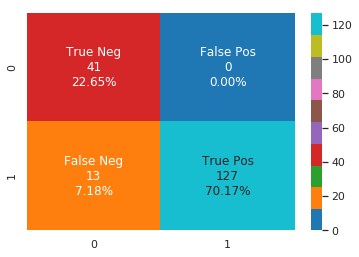

In [41]:
class_labels = list(validation_generator.class_indices.keys())

report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report) 

print('Confusion Matrix')
mat = confusion_matrix(y_true, y_pred)
print(mat)


plt.figure(idx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in mat.flatten()/np.sum(mat)]
labels = [v1 + '\n' + v2 + '\n' + v3 for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(mat, annot=labels, fmt='', cmap="tab10") #tab10 for colorblind otherwise use blues, etc.

#### Quantized Model Outcome Distribution

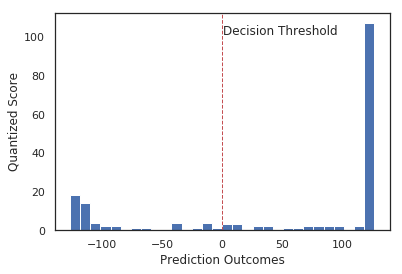

In [42]:
plt.hist(preds, density=False, bins=30)  # `density=False` would make counts
plt.axvline(0, color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(1.1, max_ylim*0.9, 'Decision Threshold')
plt.ylabel('Quantized Score')
plt.xlabel('Prediction Outcomes')
plt.show()